In [1]:
# libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Flatten, Dense,  Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# GPU cheking
print('n_GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

n_GPUs available: 1


(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


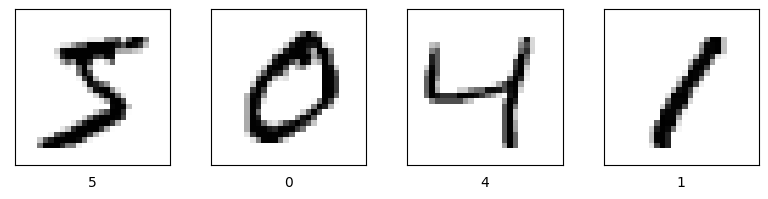

In [2]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# normalization
X_train = X_train/255
X_test = X_test/255

# check data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

# plot
n = 4
fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(8, 2))

for index, (image, label) in enumerate(tuple(zip(X_train, y_train))[0:n]):
    ax[index].imshow(image, cmap=plt.cm.binary)
    ax[index].set_yticks([])
    ax[index].set_xticks([])
    ax[index].set_xlabel(label)

plt.tight_layout()
plt.show()

n_classes: 10


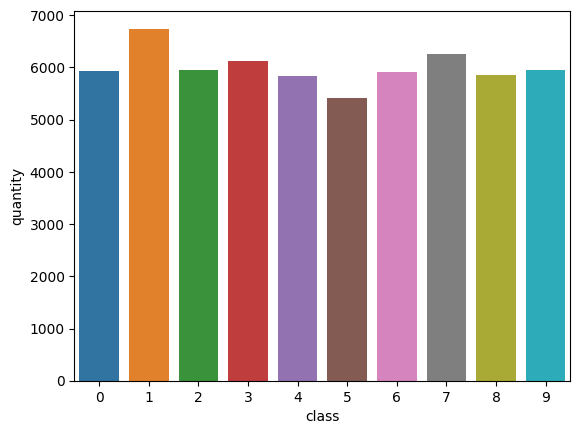

In [3]:
# classes checking
if len(np.unique(y_train)) and len(np.unique(y_test)):
    n_classes = len(np.unique(y_train))
    print(f'n_classes: {n_classes}')

# classes balance checking
unique, counts = np.unique(y_train, return_counts=True)

# plot 
sns.barplot(x=unique, y=counts)
plt.ylabel('quantity')
plt.xlabel('class')
plt.show()

In [4]:
# results visualization function
def results_visualization(log, epochs):
    
    epochs = [i for i in range(0, epochs)]
    train_accuracy = log.history['accuracy']
    train_loss = log.history['loss']
    val_accuracy = log.history['val_accuracy']
    val_loss = log.history['val_loss']

    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(16, 9)

    ax[0].plot(epochs, train_accuracy, 'go-', label='train_accuracy')
    ax[0].plot(epochs, val_accuracy, 'ro-', label='val_accuracy')
    ax[0].set_title('train - val accuracy')
    ax[0].legend()
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')

    ax[1].plot(epochs, train_loss, 'go-', label='train_loss')
    ax[1].plot(epochs, val_loss, 'ro-', label='val_loss')
    ax[1].set_title('train - val loss')
    ax[1].legend()
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

# no convolutional model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 50)                39250     
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
96/96 [==============================] - 1s 4ms/step - loss: 1.1924 - accuracy: 0.7050 - val_loss: 0.4627 - val_accuracy: 0.8843
Epoch 2/50
96/96 [==========================

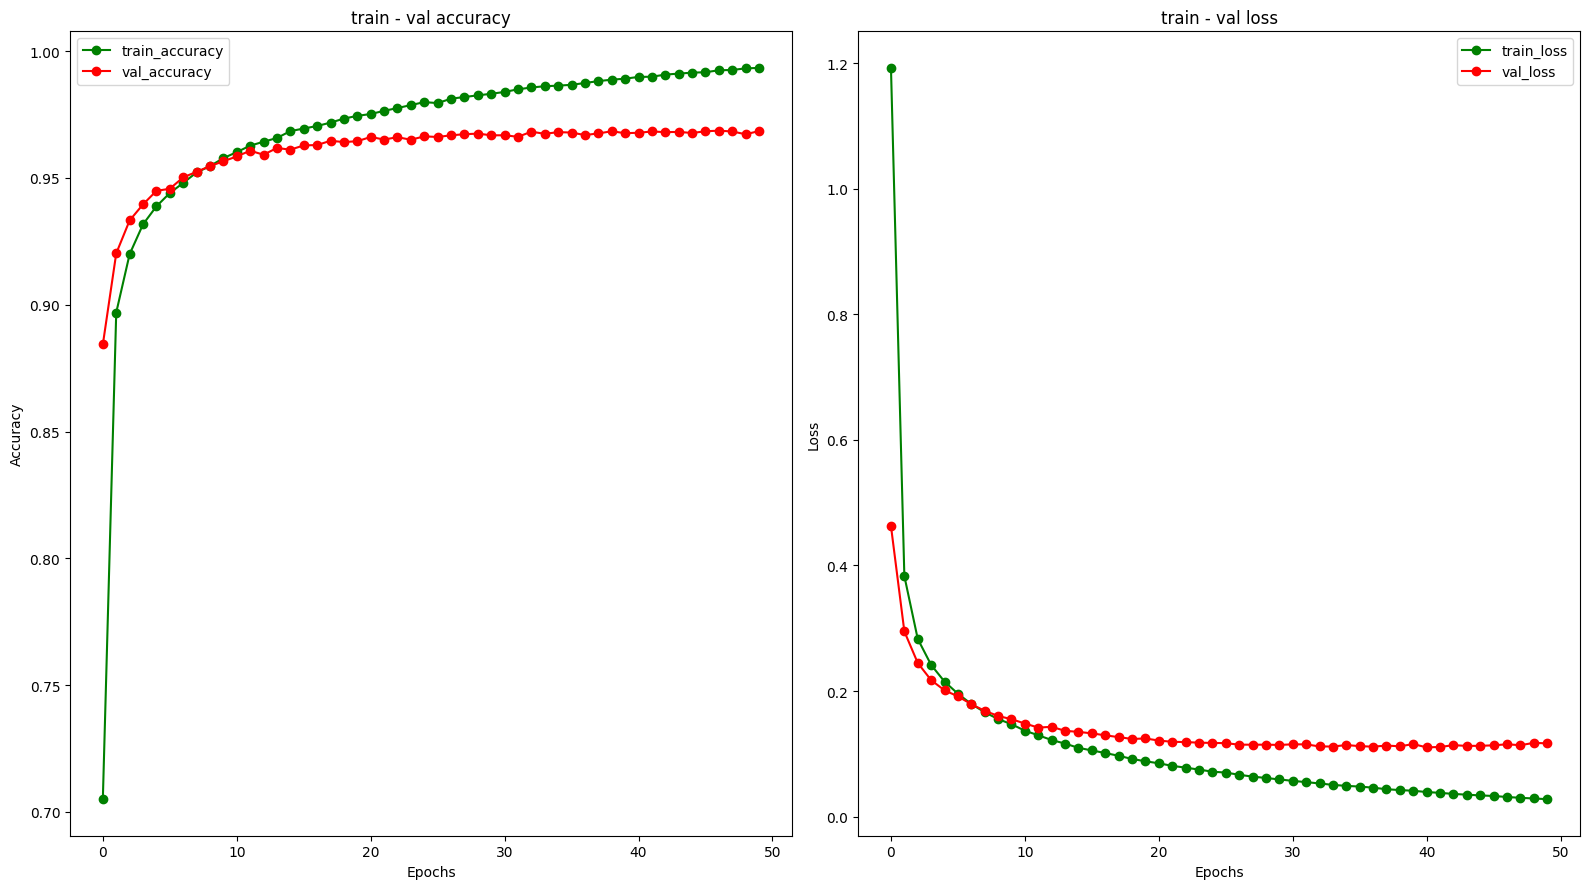

Test results (basis_model)
313/313 [==============================] - 0s 1ms/step - loss: 0.1077 - accuracy: 0.9704


In [5]:
basis_model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(units=50, activation='relu'),
    Dense(units=50, activation='relu'),
    Dense(units=n_classes, activation='softmax'),
])

basis_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

basis_model.summary()

epochs=50
y_train_onehot = tf.one_hot(y_train, n_classes)
log = basis_model.fit(X_train, y_train_onehot,
                      epochs=epochs,
                      batch_size=500,
                      shuffle=True,
                      validation_split=0.2)

results_visualization(log, epochs)

y_test_onehot = tf.one_hot(y_test, n_classes)
print('Test results (basis_model)')
results = basis_model.evaluate(X_test, y_test_onehot)

# convolutional and regularized model

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 46)        1196      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 46)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 92)        105892    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 92)         0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 7, 7, 92)          0         
                                                                 
 batch_normalization_2 (Batc  (None, 7, 7, 92)        

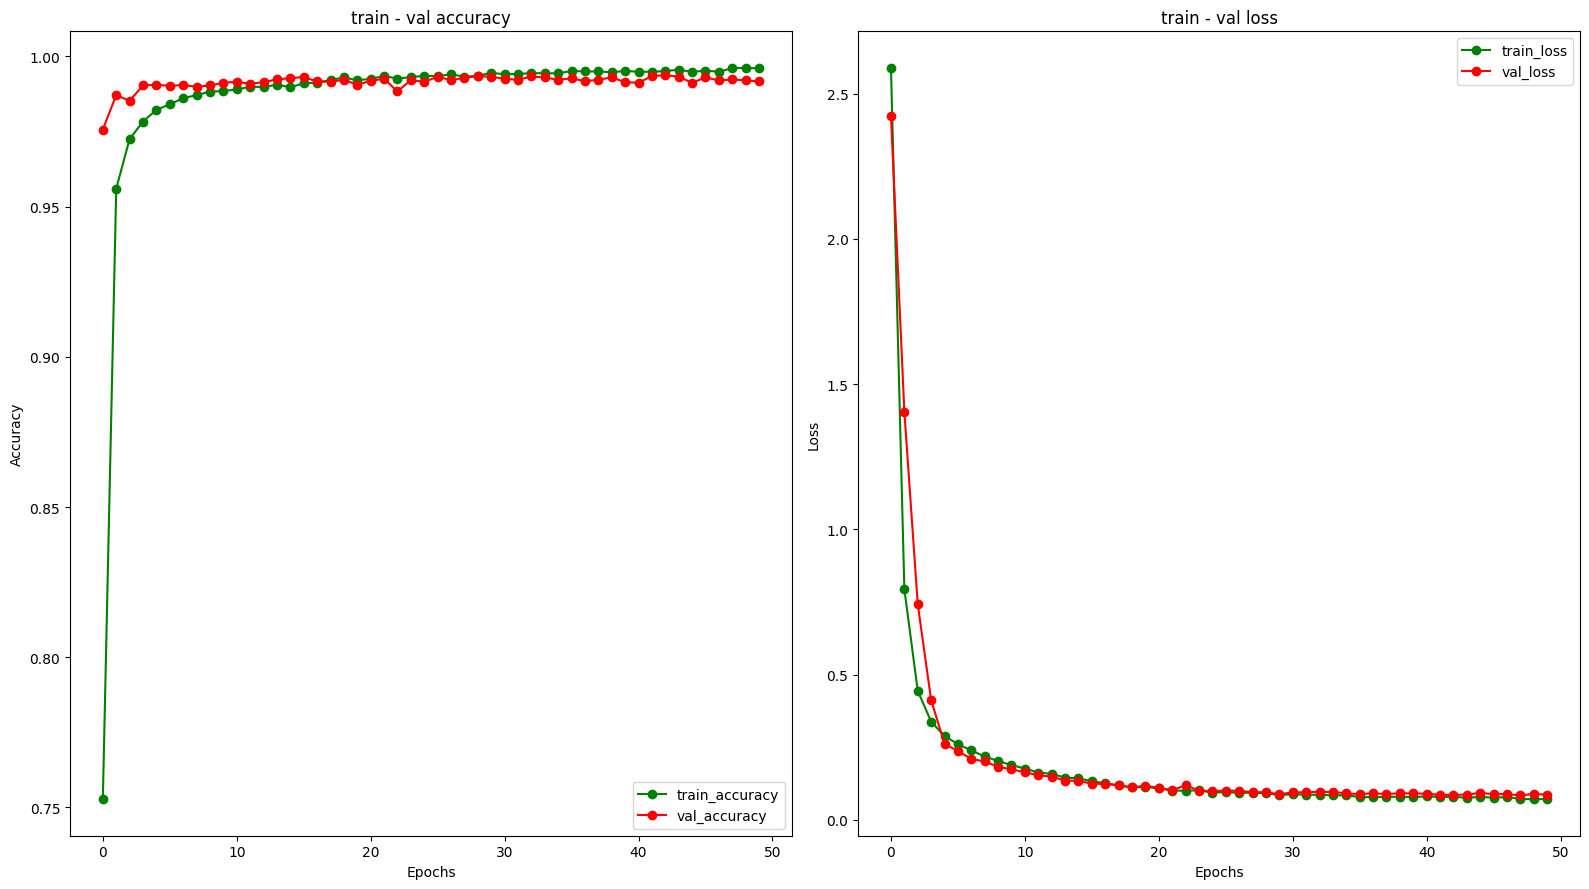

Test results (conv_model)
313/313 [==============================] - 1s 2ms/step - loss: 0.0785 - accuracy: 0.9937


In [10]:
conv_model = Sequential([
    Conv2D(filters=46, kernel_size=(5, 5), strides=1, input_shape=(28, 28, 1), padding='same', activation='relu'), # strides=1 is 1 pixel kernel displacement and padding='same' generate same input/output size
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'), # size reduction
    Conv2D(filters=92, kernel_size=(5, 5), strides=1, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'),
    Dropout(0.2), # regularization
    BatchNormalization(),
    Flatten(),
    Dense(units=150, activation='relu', kernel_regularizer=regularizers.l2(1e-2)), # l2 is ridge regularization
    Dropout(0.5),
    Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    Dropout(0.25),
    Dense(units=75, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
    Dropout(0.15),
    Dense(units=n_classes, activation='softmax'),
])

conv_model.compile(optimizer=Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy'])

conv_model.summary()

epochs = 50
log = conv_model.fit(X_train, y_train_onehot,
                      epochs=epochs,
                      batch_size=500,
                      shuffle=True,
                      validation_split=0.15)

results_visualization(log, epochs)

print('Test results (conv_model)')
results = conv_model.evaluate(X_test, y_test_onehot)

313/313 [==============================] - 0s 1ms/step


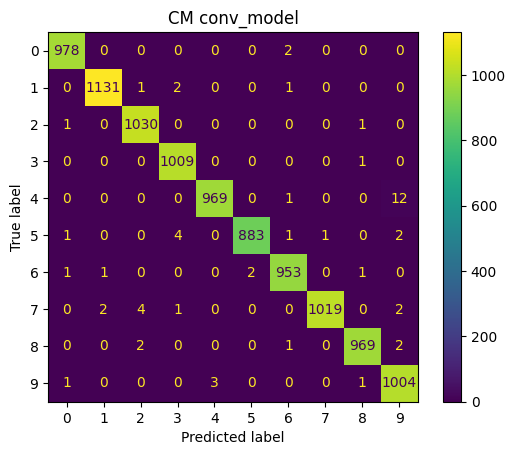

In [7]:
# predictions
y_hat = conv_model.predict(X_test)
y_hat_round = np.argmax(y_hat, axis=1)

# confusion matrix
cm_conv = confusion_matrix(y_test, y_hat_round)
disp_conv = ConfusionMatrixDisplay(cm_conv)
disp_conv.plot()
plt.title('CM conv_model')
plt.show()

In [8]:
# saving the model
conv_model.save('mnist.h5')